---
# **Advanced Lane Detection**
---
### Pipeline to Detect Lane boundaries on the road 

## Goal : 
    
The goal of this project is to dynamically detect the lane boundaries drawn on the road from individual frames  of the video and draw the detected lane lines on the original frames

## Steps :

   1. Calibrate the camera to compute matrices used to undistort the images
   2. Undistort the images using the matrices calculated in step 1. 
   3. Apply color and gradient thresholds to detect lane line pixels.
   4. Warp the image by changing perspective to a bird's-eye view of the road so that the lane lines appear rougly   parallel.
   5. Apply a sliding window search to the warped binary image to get the indicies of the lane pixels.
   6. Fit a polynomial to each of left and right lane pixels found in previous steps.
   7. Draw the Detected lanes back to each individual frame of the video.

## **Step 0:  Imports**
    Import all the necessary libraries

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def beforeAfter(before, after, before_title, after_title, first_gray=False, second_gray=False):
    """
        Helper function to display before and after images!
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9))
    f.tight_layout()
    ax1.set_title(before_title, fontsize=30)
    ax2.set_title(after_title, fontsize=30)
    if first_gray:
        ax1.imshow(before, cmap='gray')
    else:
        ax1.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    if second_gray:
        ax2.imshow(after, cmap='gray')
    else:
        ax2.imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))

    

## **Calibrating the camera**
---
In the code cell below, the camera is calibrated by using the images of a 9x6 chessboard. The calculated camera matriX and distortion coefficients are saved in a pickle file for later use

In [5]:
FILE_NAME = './pickle.p'

# number of internal corners in the chessboard images
nx = 9
ny = 6

def getCalibrtionPoints(images):
    """
        Function to get image points and object points from the given calibration images
        Args : 
            images : List of file paths of the images
        Returns : 
            (objpoints, imgpoints) : The mapping of image points to image plane
    """
    
    
    # Prepare object points. These will be all in the image plane (z = 0)
    # These are of the format (0,0,0), (1,0,0) ... 
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Lists to hold image points and object points
    objpoints = []
    imgpoints = []

    for fname in images:
        # Read the image
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find Corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        # If Corners are found append them to lists.
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

def saveDistortionPickle(images):
    """
        Calculates the undistortion matricies for the camera and saves them in a pickle file.
        Args : 
            images : List of file paths of the provided calibration images
    """
    # Compute imagepoints and objectpoints
    objpoints, imgpoints = getCalibrtionPoints(images)
    
    # A test image to extract shape from
    test_img = cv2.imread('./camera_cal/calibration3.jpg')
    img_size = (test_img.shape[1], test_img.shape[0])
    
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Save the pickle
    dist_pickle = {'dist' : dist, 'mtx' : mtx}
    pickle.dump(dist_pickle, open(FILE_NAME, 'wb'))

images = glob.glob('./camera_cal/calibration*.jpg')
saveDistortionPickle(images)

---
Now the matrices to be used to undistort the images have been calculated and saved to the pickle a pickle file
These can be later used to undistort any image taken from this particular camera

---

In [6]:
DIST = None
MTX = None
DIST_PICKLE = './pickle.p'

def undistort(img):
    """
        Undistorts The image using the computed matrices
    """
    global DIST, MTX, DIST_PICKLE
    return cv2.undistort(img, MTX, DIST, None, MTX)

def setDistMtx(p_file):
    """
        Read the pickle file and set the value of the Undistortion matrices
    """
    global DIST, MTX
    dist_pickle = pickle.load(open(p_file, 'rb'))
    DIST =  dist_pickle['dist']
    MTX = dist_pickle['mtx']

setDistMtx(DIST_PICKLE)

---
**Example of Correcting and image for distortion**

---
After running the code cell below you can see that in the original images the lines are a bit curved due to the distortion induced in the image from the camera lens. After undistorting the image the lines appear straight!

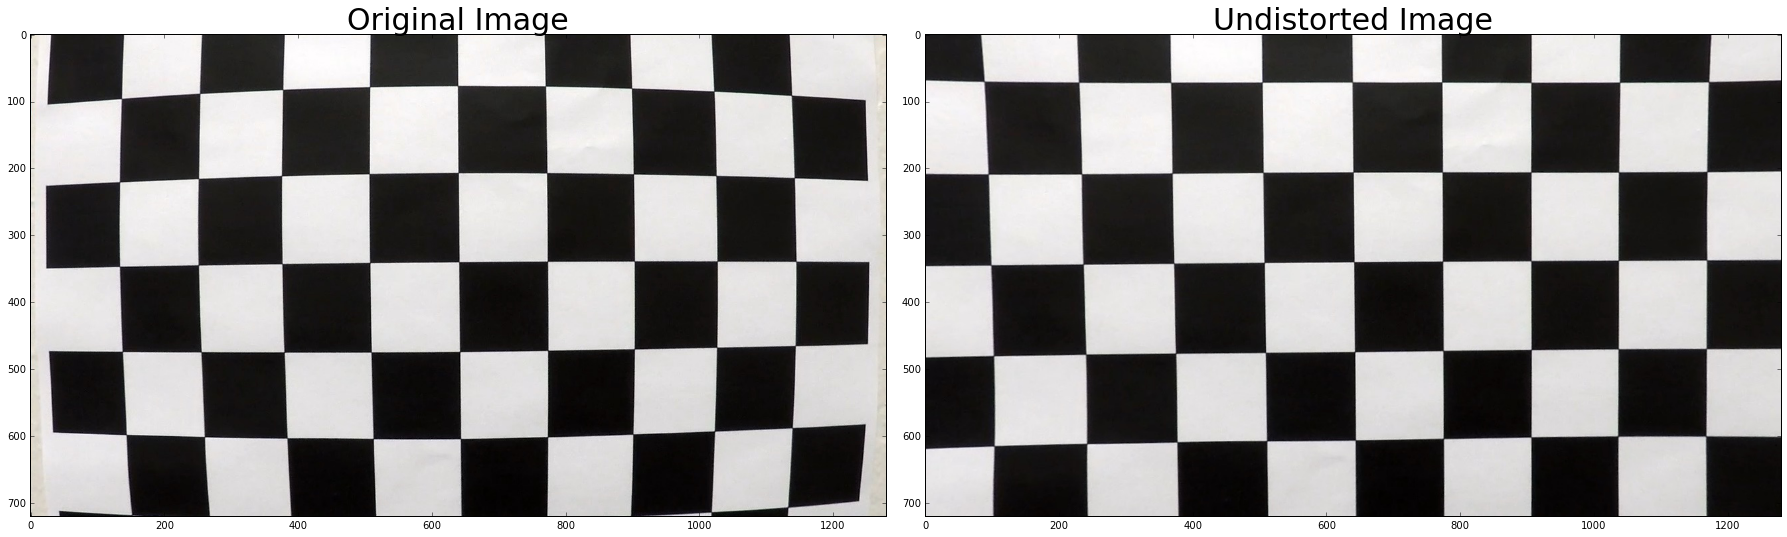

In [7]:
# Read a test image
test_image = cv2.imread('./camera_cal/calibration1.jpg')

# Undistort the image
undistorted = undistort(test_image)

# Display both the images 
beforeAfter(test_image, undistorted, 'Original Image', 'Undistorted Image')

##  **Perspective Change**
---
In the images from the camera mounted on the hood of the car, the lane lines appear converging towards each other while in reality they are parallel to each other. From a bird's-eye view the lines appear roughly parallel to the each other. To get a bird's eye view, we perform a perpective transform on the image. Four source points are chosen and four destination points are chosen in a way so that in the transformed image the lane lines appear roughly parallel

In [8]:
# Four source points and four destination points in anticlockwise order
src_points = np.float32([[300, 660],
                 [1016,660],
                 [720, 470],
                 [567, 470]])
dst_points = np.float32([[400, 720],
                 [880, 720],
                 [880, 0],
                 [400, 0]])

# Compute warp and unwarp matrices
M = cv2.getPerspectiveTransform(src_points, dst_points)
M_inv = cv2.getPerspectiveTransform(dst_points, src_points)

# Helper functions to warp and unwarp images
def warp(img):
    global M
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

def unwarp(img):
    global M_inv
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M_inv, img_size, flags=cv2.INTER_LINEAR)

---
**Example of performing a perspective transform**

---
After running the code cell below you can see that in the original images the lane lines are appearing to be converging towards each other. After performing a perspective transform the lines appear roughly parallel

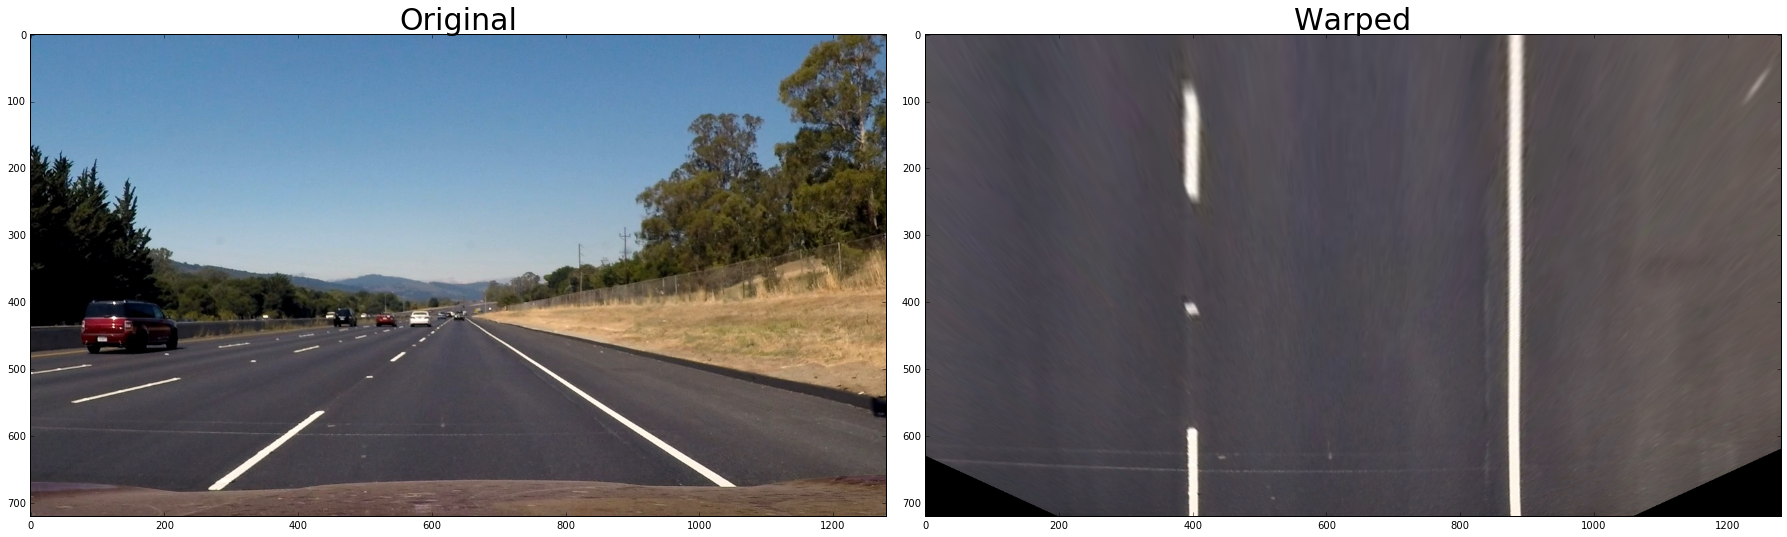

In [9]:
test_image = cv2.imread('./test_images/straight_lines2.jpg')
warped = warp(test_image)
beforeAfter(test_image,warped, 'Original', 'Warped')

## Step 3: Color Thresholding 
---
Some colors are more prominent in some color spaces than they are in others. For example the yellow color can be easily detected in the 's' channel of 'hls' or 'hsv' color space. Moreover shadows and excessive lighting affects 'l' channel of 'hls' color space while the saturation and hue information is preserved. The white lines are easily detected in many color spaces. For simplicity I used 'rgb'

---
**Helper function to make experimenting with color thresholding easier**


In [10]:
# Helper functions to play with color channels
def getSingleChannel(img, channel='r', space='rgb'):
    """
        Converts the image to specified color space and
        returns the specific channel of color
        
        Args :
            img : The input image (BGR colorspace)
            channel : single channel of color to extract
            space : Color space
        Returns :
            image with the single color channel
    """
    if space == 'hls':
        convert = cv2.COLOR_BGR2HLS
    elif space == 'rgb':
        convert = cv2.COLOR_BGR2RGB
    elif space == 'hsv':
        convert = cv2.COLOR_BGR2HSV
    elif space == 'yuv':
        convert = cv2.COLOR_BGR2YUV
    elif space == 'luv':
        convert = cv2.COLOR_BGR2LUV
    elif space == 'gray':
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        assert 1 == 0, "Choose one of hsv, rgb, hsv, hls"
    
    if convert is not None:
        src = cv2.cvtColor(img, convert)
    
    selector = space.find(channel)
    assert selector != -1, "Channel not in space"
    return src[:,:,selector]

def getColorThresholdBinary(img, channel='r', space='rgb', threshold=(0,255)):
    """
        Applies color threshold to the single specified channel of the image
        Args : 
            img : The input image (BGR color space)
            channel : The channel to threshold
            space : The color space to use
            threshold : (Max and min values for threshold)
        Returns : 
            Binary color thresholded image
    """
    src = getSingleChannel(img, channel, space)
    return get_binary(src, threshold)

def get_binary(src, threshold=(0, 255)):
    """
        Applies the given threshold to the image and returns a binary Image
        Args : 
            src : Source image
        Returns :
            binary : The binary thresholded image
    """
    binary = np.zeros_like(src, dtype=np.uint8)
    cond = ((src >= threshold[0]) & (src <= threshold[1]))
    binary[cond] = 1
    return binary

**Example of color space change and color Thresholding**

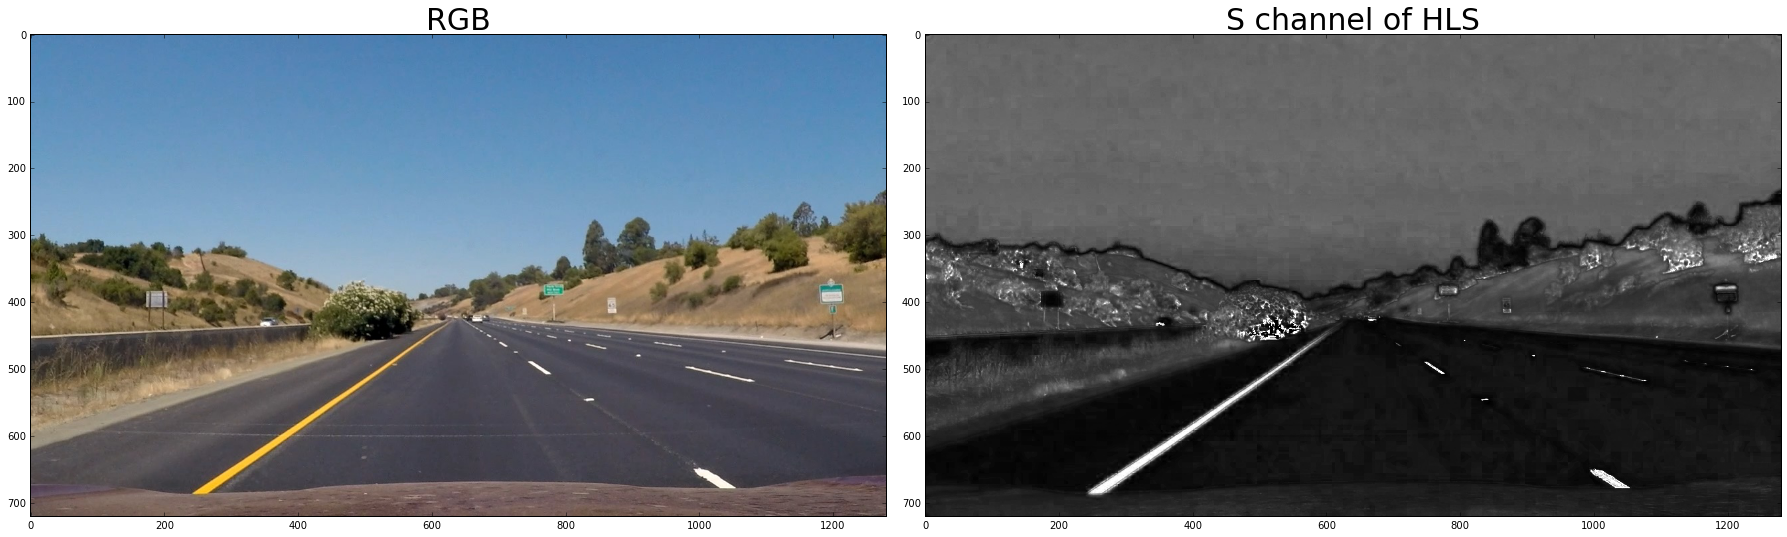

In [11]:
test_image = cv2.imread('./test_images/straight_lines1.jpg')
S = getSingleChannel(test_image, 's', 'hls')
beforeAfter(test_image, S, 'RGB', 'S channel of HLS', False, True)

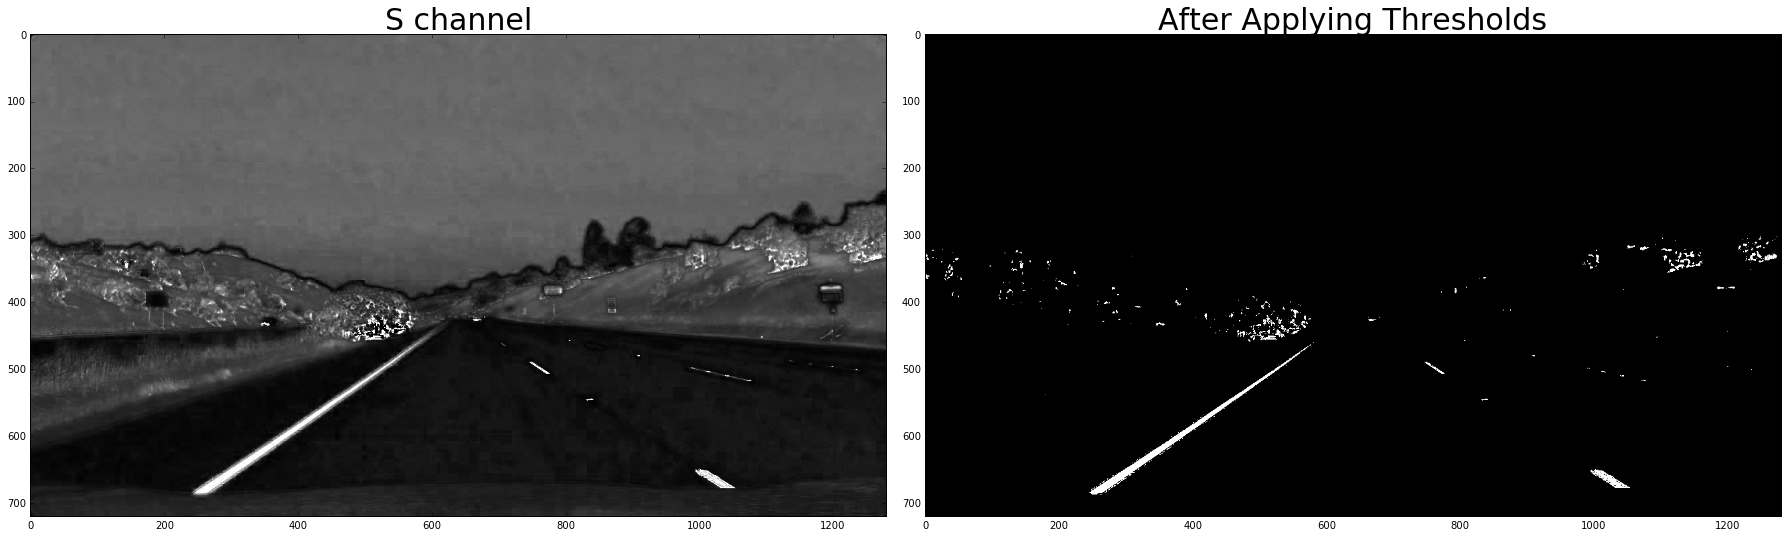

In [12]:
# Example of applying thresholds
S_thresholded = getColorThresholdBinary(test_image, 's', 'hls', (170, 255))
beforeAfter(S, S_thresholded, 'S channel', 'After Applying Thresholds', True, True)

## **Calculating gradient**
In addition to  thresholding the color channels another way to detect the lane lines is by calculating gradient to detect edges in an image. With the help Sobel operator it is possible to calculate the gradient in 'x' or 'y' directions. After calculating gradient only edges above a particular value of gradient are chosen. Gradients are calculated for individual color channels in the same was done in color thresholding

**The gradient can be calculated in the following ways**
    1. By taking gradient in particular 'x' or 'y' direction only
    2. By taking the magnitude of gradient from the gradients calculated in both 'x' and 'y' directions
    3. By calculating the directions of edges from the gradients calculated in both 'x' and 'y' directions
**Final output is calculated by choosing a combination of above three methods**

---

**Helper functions to accomplish the tasks listed above**

---


In [13]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255), kernel_size=3):
    """
        Calculate Gradient in 'x' or 'y' direction and apply threshold
        to binary image
        Args : 
            img : The Input image with single channel
            orient : x or y
            thresh : Tuple of (minimum, maximum) absolute gradient 
            kernel_size: Size of Sobel kernel to be used
        Returns : 
            Thresholded binary image
    """
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    else :
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return get_binary(scaled_sobel, thresh)

def mag_thresh(img, ksize=3, thresh=(0, 255)):    
    """
        Calculate magnitude of gradient in both x and y directions and 
        apply threshold to binary image
        Args:
            img : The input image with single channel
            ksize : Kernel Size to be Used
            thresh : Tuple of (min, max) value of gradient
        Returns :
            Binary Thresholded Image
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    return get_binary(gradmag, thresh)

def dir_threshold(img, ksize=3, thresh=(0, np.pi/2)):
    """
        Calculate directional gradient and threshold the image
        Args:
            img : Input image with single channel
            ksize : Kernel size
            thresh : Tuple of (min, max) angle
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    return get_binary(absgraddir, thresh)

def gradientThreshold(img, channel='r', space='rgb', kind='dir', ksize=3, threshold=(0, 255)):
    """
        Chooses appropriate gradient out of directional, magnitude and absolute
        and applies it to the input image and returns a binary image.
        Args:
            img : The input image in BGR color space
            space : The color space to convert to
            channel : The color channel to calculate gradient of
            kind : Absolute(abs), Magnitude(mag), x or y gradient
            ksize : kernel size of sobel filter
            threshold : (Min, Max) values of gradient allowed
        Returns :
            Binary Thresholded Image
    """
    src = getSingleChannel(img, channel, space)
    if kind == 'dir':
        return dir_threshold(src, ksize=ksize, thresh=threshold)
    elif kind == 'mag':
        return mag_thresh(src, ksize=ksize, thresh=threshold)
    elif kind == 'x':
        return abs_sobel_thresh(src, orient='x', thresh=threshold,
                                kernel_size=ksize)
    elif kind == 'y':
        return abs_sobel_thresh(src, orient='y', thresh=threshold,
                                kernel_size=ksize)
    else:
        assert False, 'Use Correct kind(x, y, mag, dir)'

---
**Examples of taking gradient of the images**

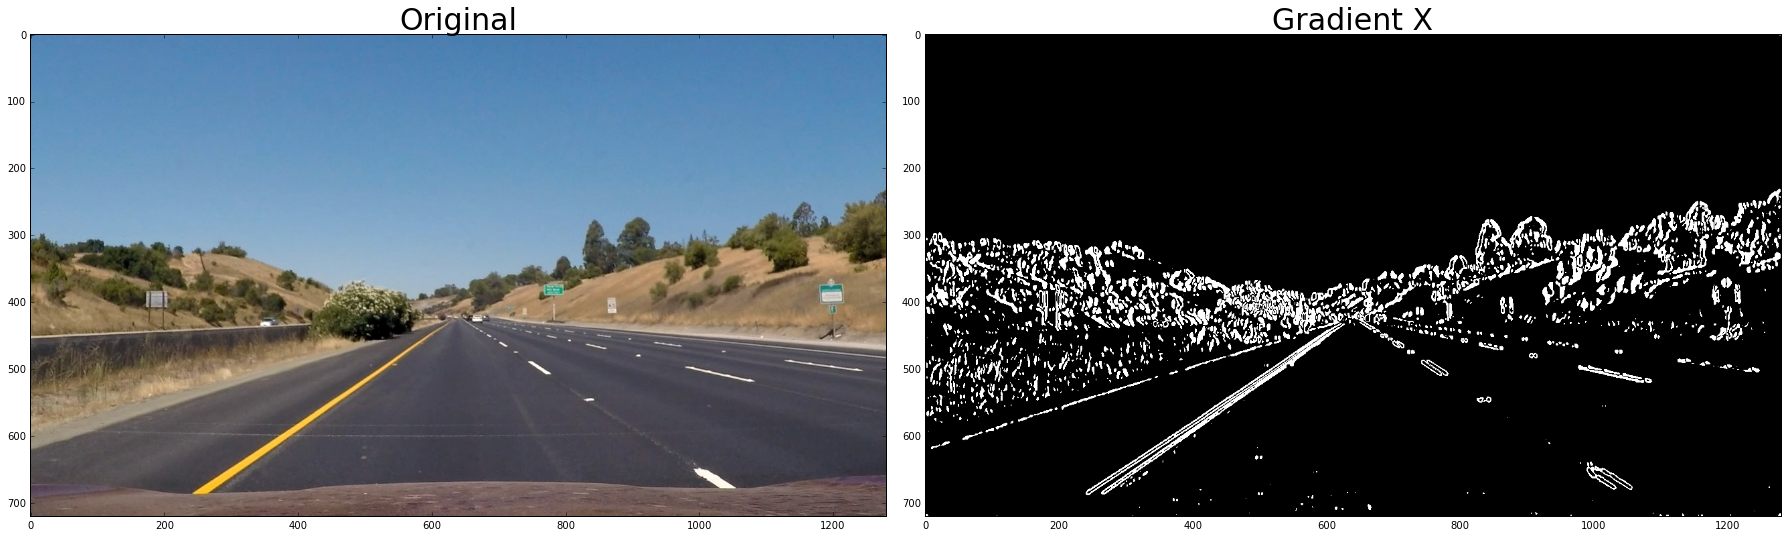

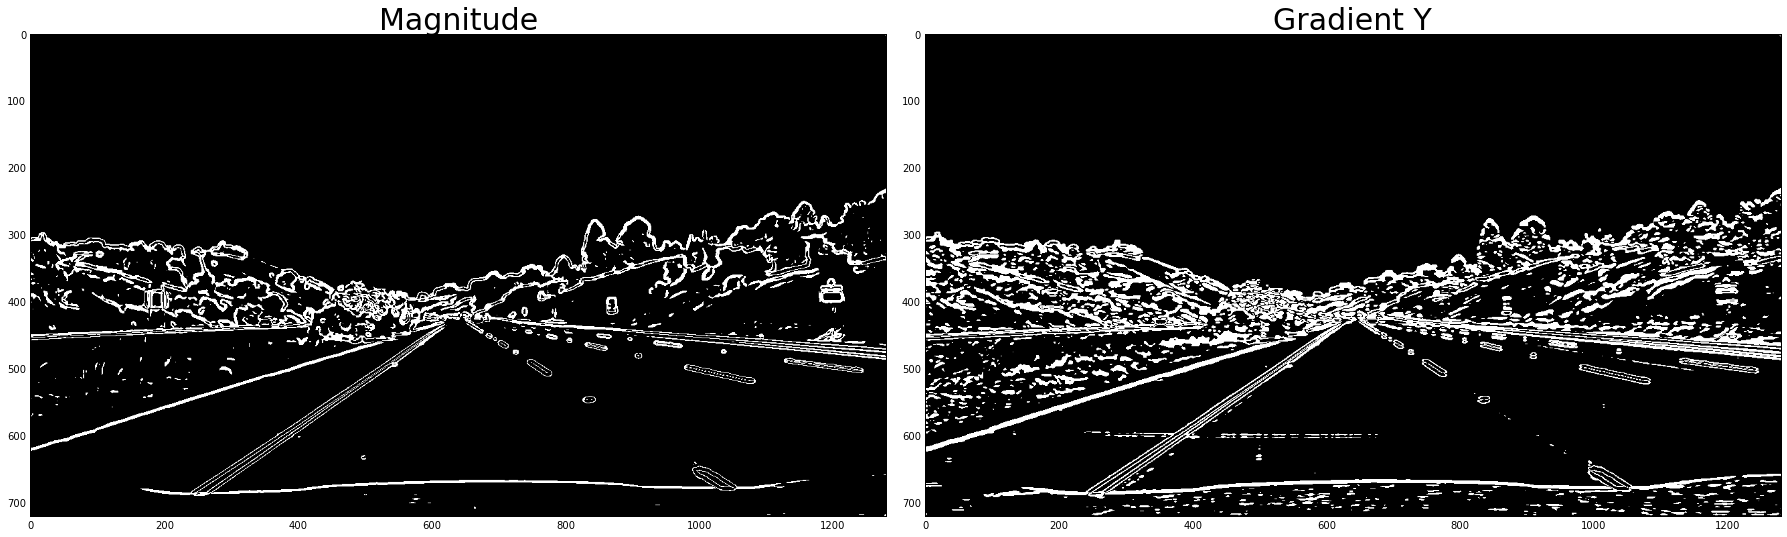

In [14]:
test_image = cv2.imread('./test_images/straight_lines1.jpg')

# Take gradient in x direction
X = gradientThreshold(test_image, 'g', 'gray', 'x', 13, (20, 100))
# Take gradient in y direction
Y = gradientThreshold(test_image, 'g', 'gray', 'y', 13, (20, 100))
M = gradientThreshold(test_image, 'g', 'gray', 'mag', 13, (40, 100))
beforeAfter(test_image, X, 'Original', 'Gradient X', False, True)
beforeAfter(M, Y, 'Magnitude', 'Gradient Y', True, True)

---
## **Combining Color and gradient Thresholds**
To get the best result for detecting lane line pixels, the binary color and gradient thresholded images are combined by doing bitwise 'and' and 'or' operations

**Helper function to combine binary images**

---

In [15]:
def threshold(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    lower_yellow = np.array([0, 100, 100])
    upper_yellow = np.array([50, 255, 255])
    lower_white = np.array([200, 200, 200])
    upper_white = np.array([255, 255, 255])

    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    white_mask = cv2.inRange(rgb, lower_white, upper_white)

    w_y = yellow_mask | white_mask


    Xs = gradientThreshold(img, 's', 'hls', 'x', 19, (50, 200))
    Ds = gradientThreshold(img, 's', 'hls', 'dir', 19, (0.7, 1.2))
    
    V = getColorThresholdBinary(img, 'v', 'luv', (180, 255))
    XV = gradientThreshold(img, 'v', 'luv', 'x', 13, (50,200))

    poly_vertices = np.array([[0,720], [1280, 720], [800, 400], [400, 400]])
    mask = np.zeros_like(Xs)
    cv2.fillPoly(mask, [poly_vertices], 1)
    
    return cv2.bitwise_and((((Ds & Xs) | w_y)), mask)

In [16]:
def preprocess(image):
    """
        Expects a binary image
        Warps the thresholded binary image and sets outliers to 0
    """
    result = warp(threshold(image))
    result[:, :230] = 0
    result[:,1100:] = 0
    return result

**Example of combining color and gradient threshold**

---
**If you get an error here in the warp function go up and run the code cell where warp and unwarp functions are defined**

In [18]:
# Four source points and four destination points in anticlockwise order
src_points = np.float32([[300, 660],
                 [1016,660],
                 [720, 470],
                 [567, 470]])
dst_points = np.float32([[400, 720],
                 [880, 720],
                 [880, 0],
                 [400, 0]])

# Compute warp and unwarp matrices
M = cv2.getPerspectiveTransform(src_points, dst_points)
M_inv = cv2.getPerspectiveTransform(dst_points, src_points)

# Helper functions to warp and unwarp images
def warp(img):
    global M
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

def unwarp(img):
    global M_inv
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M_inv, img_size, flags=cv2.INTER_LINEAR)

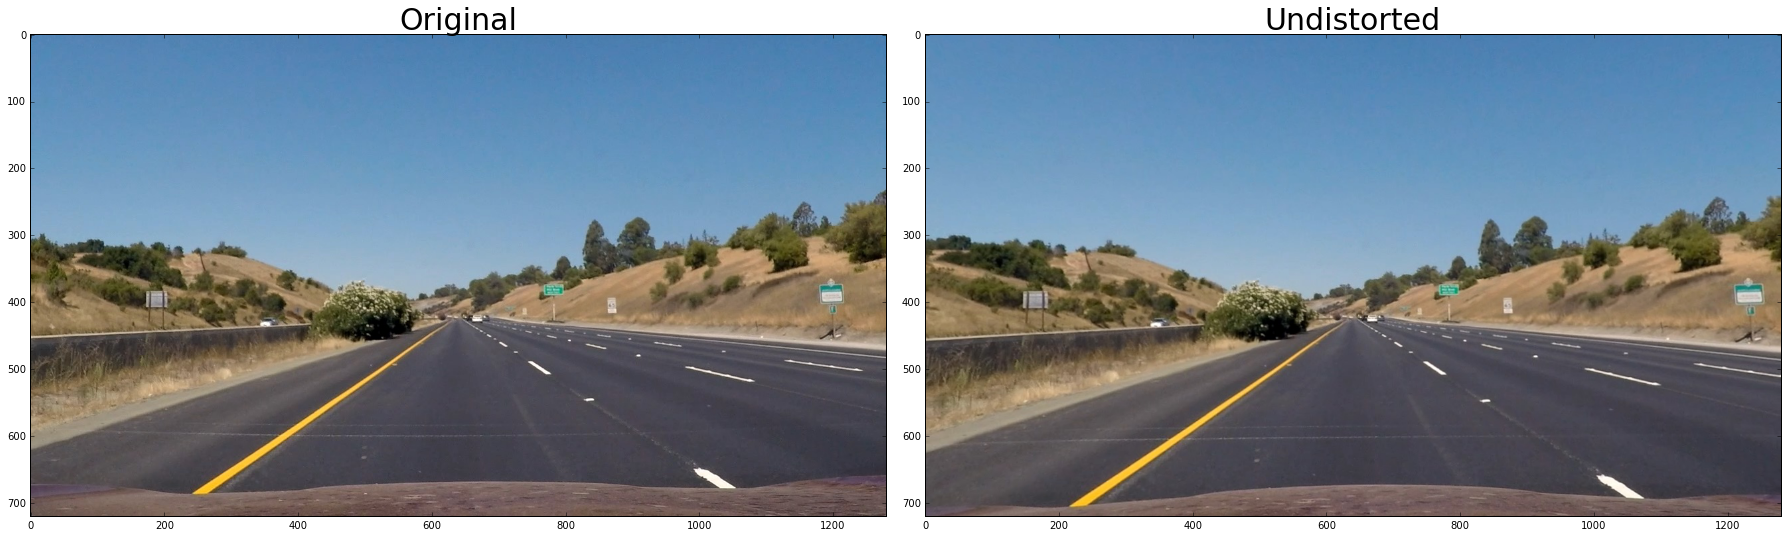

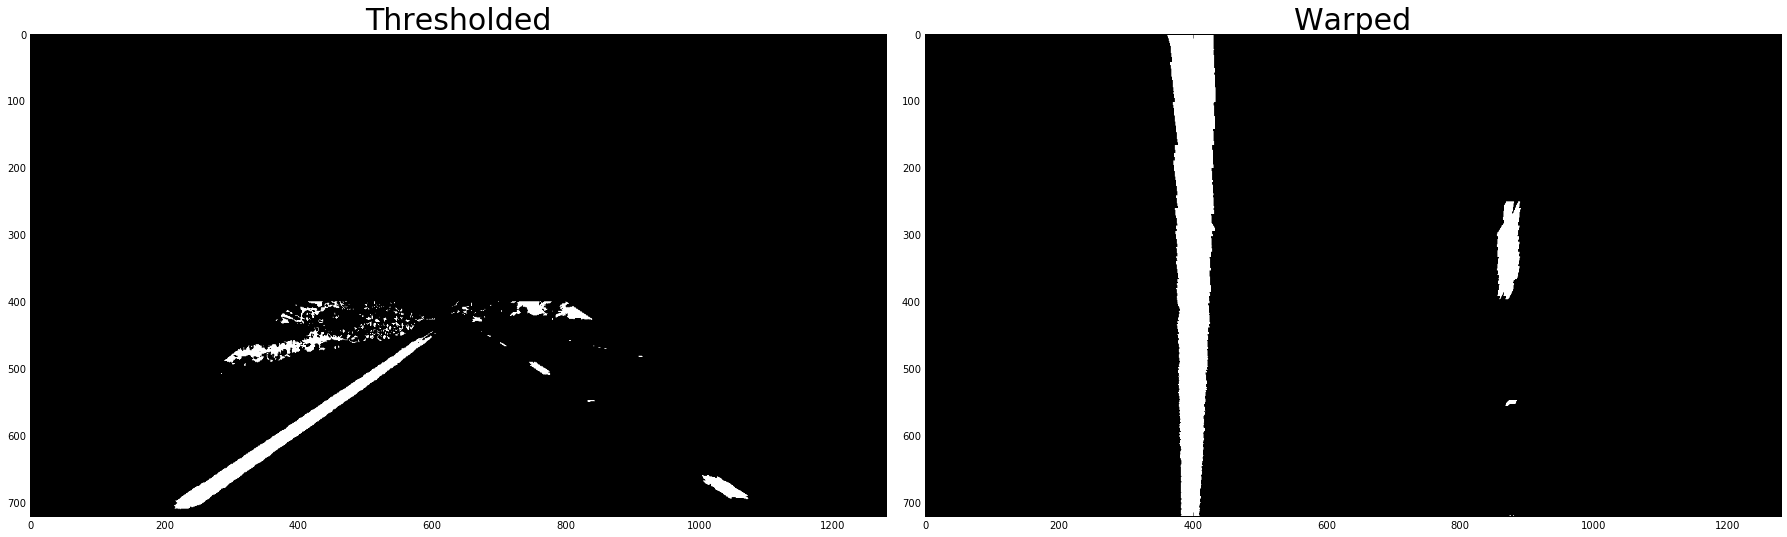

In [19]:
test_image = cv2.imread('./test_images/straight_lines1.jpg')
undist = undistort(test_image)
thresholded = threshold(undist)
warped = preprocess(undist)
beforeAfter(test_image, undist, 'Original', 'Undistorted', False, False)
beforeAfter(thresholded, warped, 'Thresholded', 'Warped', True, True)

---
## Finding Lane lines form the warped Binary Image
---
In order to find the pixels in the binary warped image a sliding window search is applied to the image. After identifying lane line pixels from both left and right lines, polynomials of second degree are fitted.

The following steps are used to identify the pixels:

**1. Find the starting points of left and right lane lines**

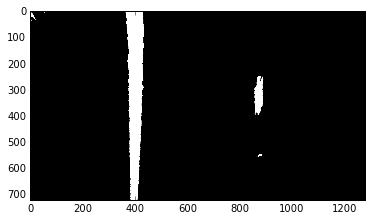

In [20]:
image = cv2.imread('./test_images/straight_lines1.jpg')
undist = undistort(image)
thresholded = threshold(undist)
warped = warp(thresholded)
plt.imshow(warped, cmap='gray')

In [21]:
# Define a convolution window 
window_width = 50
window_height = 80
margin = 100

# window
window = np.ones(window_width)

X = warped.shape[1]
Y = warped.shape[0]

# Take histogram of bottom quarter and left half of the binary warped image 

l_sum = np.sum(warped[int(3*Y/4):, :int(X/2)], axis=0)
l_conv_signal = np.convolve(window, l_sum)
l_center = np.argmax(l_conv_signal) - window_width/2

r_sum = np.sum(warped[int(3*Y/4):, int(X/2):], axis=0)
r_conv_signal = np.convolve(window, r_sum)
r_center = np.argmax(r_conv_signal) - window_width/2 + int(X/2)

---
**Visualization**

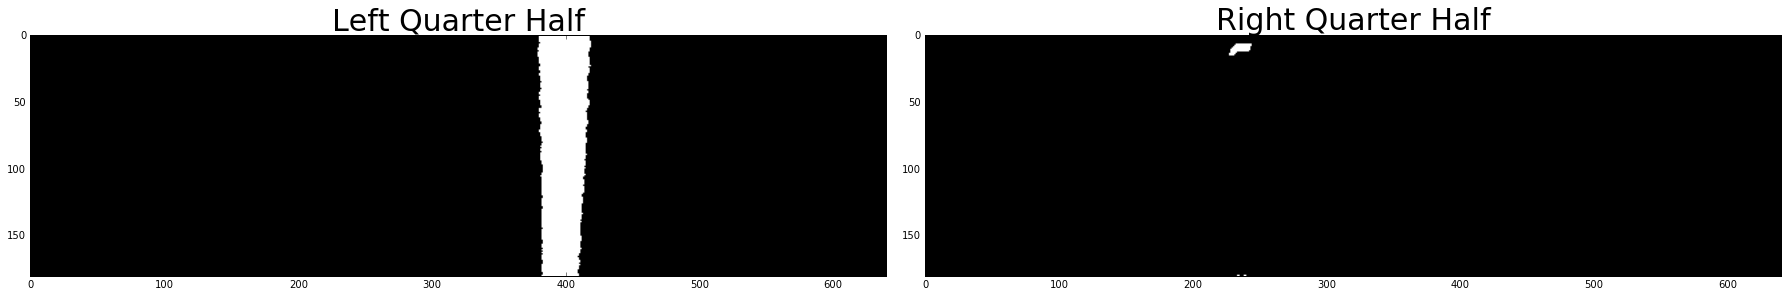

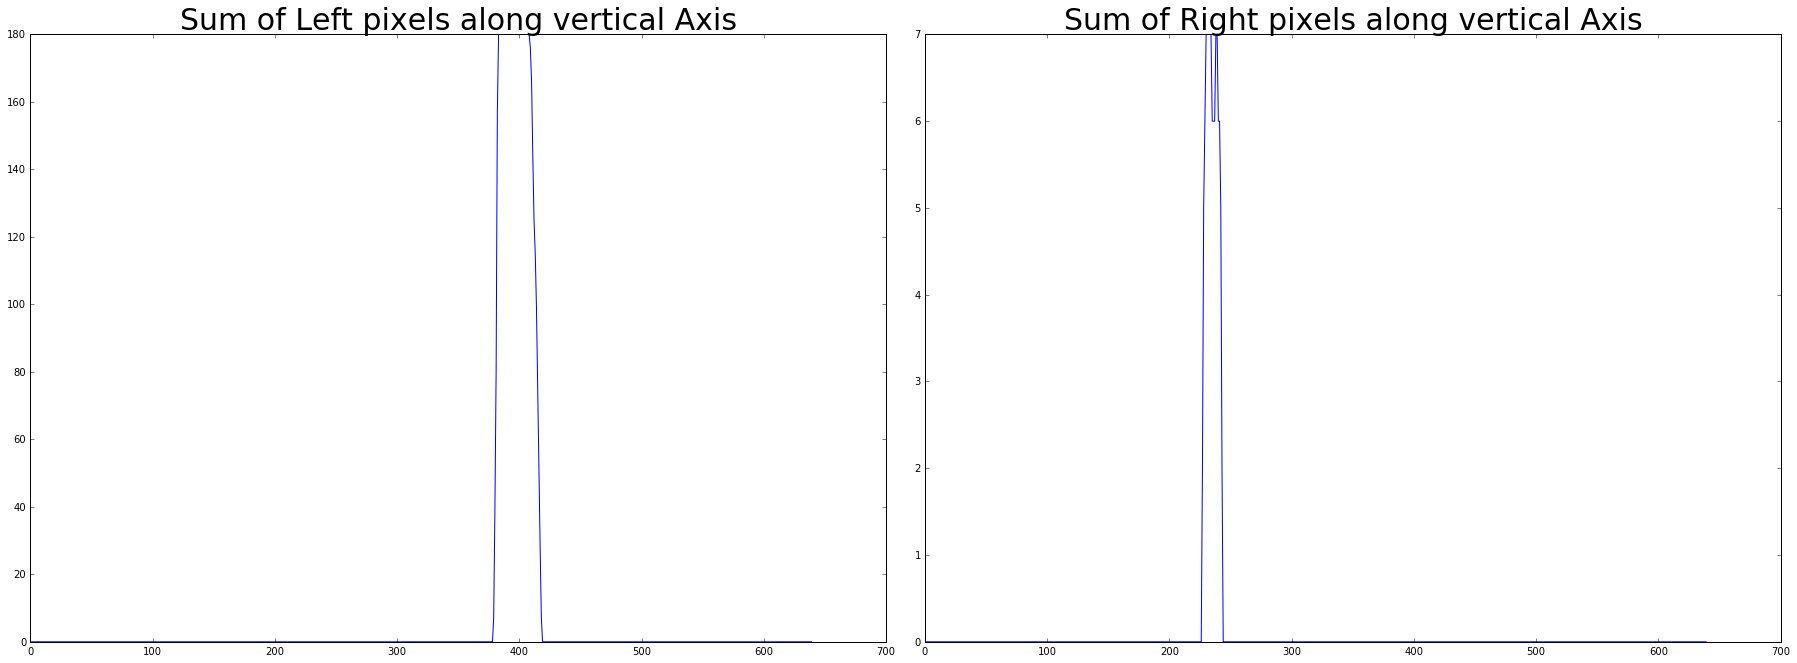

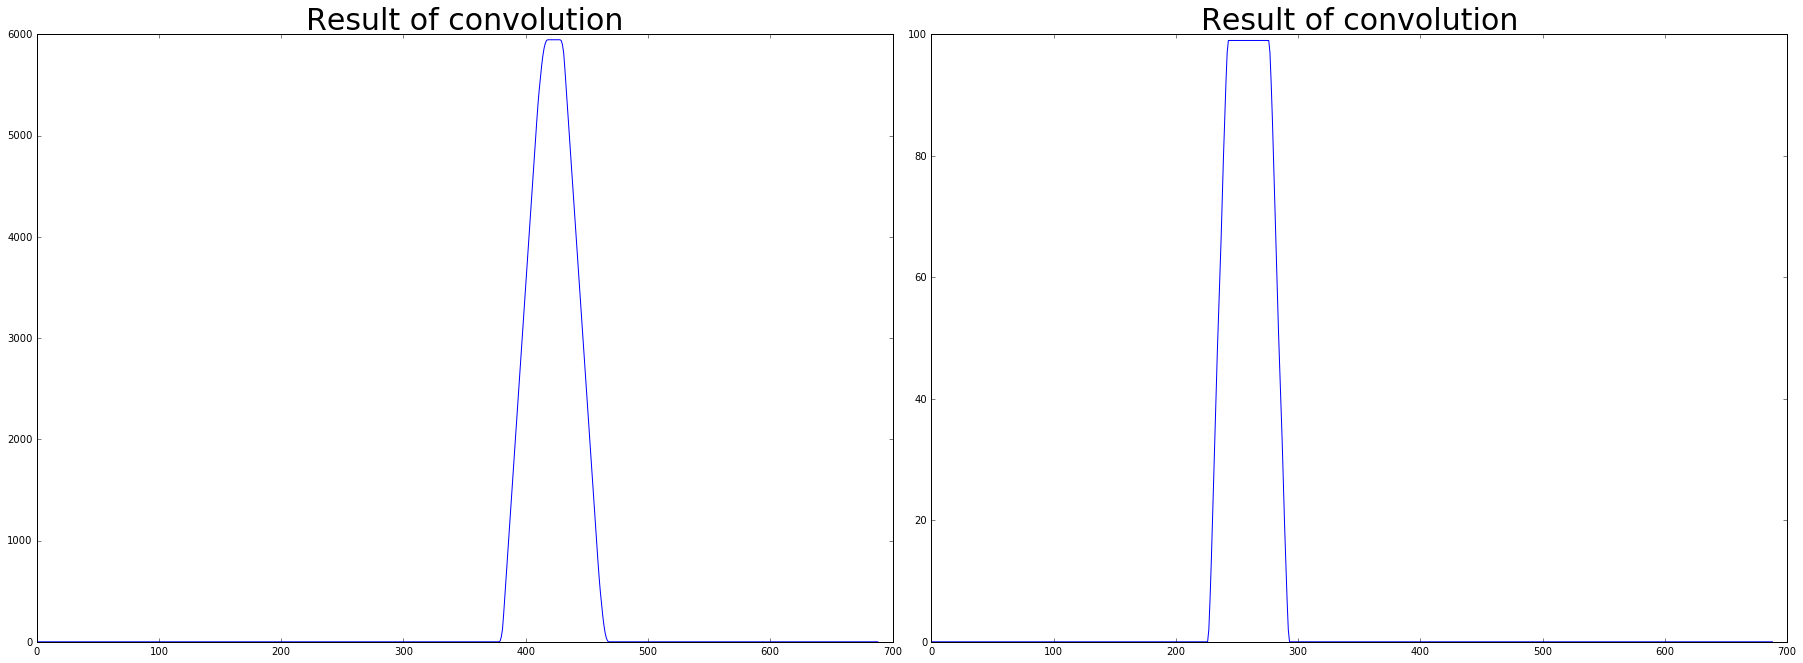

In [22]:
beforeAfter(warped[int(3*Y/4):, :int(X/2)], warped[int(3*Y/4):, int(X/2):], "Left Quarter Half", "Right Quarter Half", True, True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,9))
f.tight_layout()
ax1.set_title("Sum of Left pixels along vertical Axis", fontsize=30)
ax2.set_title("Sum of Right pixels along vertical Axis", fontsize=30)
ax1.plot(l_sum)
ax2.plot(r_sum)
plt.show()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,9))
f.tight_layout()
ax1.set_title("Result of convolution", fontsize=30)
ax2.set_title("Result of convolution", fontsize=30)
ax1.plot(l_conv_signal)
ax2.plot(r_conv_signal)
plt.show()

In [23]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    y = img_ref.shape[0]
    x = img_ref.shape[1]
    output[int(y - (level+1) * height):
           int(y - (level * height)), 
           max(0, int(center-width/2)) : min(int(center+width/2),
           x)] = 1
    return output

In [24]:
def drawWindows(warped, window_centroids):
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    return output

In [25]:
def generateXYforDrawing(fit, Y):
    """
        Get the line points for plotting from fit
        
        Args :
            fit : The polynomial coeficients
            Y : Size of image along y axis(height of image)
    """
    ploty = np.linspace(0, Y-1, Y)
    fitX = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return (fitX, ploty)

In [26]:
def searchInWindow(y_min, y_max, center, margin, x, y):
    """search for nonzero indicies in a window"""
    x_min = center - margin
    x_max = center + margin
    return ((y >= y_min) & (y < y_max) & (x >= x_min) & (x < x_max)).nonzero()[0]

In [27]:
def showLanePixels(binary_warped, left_fit, right_fit, l_idx, r_idx, nonzero_x, nonzero_y):
    """highlight lane line pixels and draw a line indicting fit"""
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img[nonzero_y[l_idx], nonzero_x[l_idx]] = [255, 0, 0]
    out_img[nonzero_y[r_idx], nonzero_x[r_idx]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [34]:
def measureCurvatureAndOffset(ploty, leftx, rightx, X):
    """Measure curvature and offset from center"""
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    y = ploty*ym_per_pix
    ymax = np.max(y)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*ymax + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*ymax + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    average_roc = (left_curverad + right_curverad) / 2
    
    left_base = left_fit_cr[0]*ymax**2 + left_fit_cr[1]*ymax + left_fit_cr[2]
    right_base = right_fit_cr[0]*ymax**2 + right_fit_cr[1]*ymax + right_fit_cr[2]
    
    midpoint = (left_base + right_base)/ 2
    img_midpoint = X/2 * xm_per_pix
    offset = img_midpoint - midpoint
    
    return average_roc, offset

In [29]:
def drawOnImage(binary_warped, image, left_fit, right_fit):
    """
        Draw The fitted lines on the original image 
        Args :
            binary_warped : The warped and thresholded image
            image : The original image
            left_fit : Polynomial fit of left lane line
            right_fit : Polynomial fit of right lane line
        Returns :
            Original Image with the detected lane filled with green color
    """
    l_fitx, ploty = generateXYforDrawing(left_fit, binary_warped.shape[0])
    r_fitx = generateXYforDrawing(right_fit, binary_warped.shape[0])[0]
    
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([l_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,0,255))
    unwarped = unwarp(color_warp)
    result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)
    rad, off =  measureCurvatureAndOffset(ploty, l_fitx, r_fitx, binary_warped.shape[1])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Offset : %.2fm' %off, (50, 100), font, 1, [0,0,255], 4)
    cv2.putText(result, 'ROC : %.2fm'%rad, (50, 150), font, 1, [0,0,255], 4)
    return result

In [30]:
def getPixelIdxFromLastFit(nonzero_x, nonzero_y, fit, margin):
    """
        Function to find pixels around the region where they were found in
        the last frame
    """
    minpix = 3700
    idx = ((nonzero_x > (fit[0]*(nonzero_y**2) + fit[1]*nonzero_y + fit[2] - margin)) & (nonzero_x < (fit[0]*(nonzero_y**2) + fit[1]*nonzero_y + fit[2] + margin))).nonzero()[0]
#     print (len(idx))
    return len(idx) > minpix, idx 

In [31]:
def useLastFit(nonzero_x, nonzero_y, fit, margin):
    """search for pixels around the last fitted line"""
    ret, idx = getPixelIdxFromLastFit(nonzero_x, nonzero_y, fit, margin)
    if ret:
        # If last fit has greater than minimum pixels then return True and fit
        x = nonzero_x[idx]
        y = nonzero_y[idx]
        return ret, np.polyfit(y, x, 2)
    else:
        # If unable to use last fit, return False
        return ret, 1

In [32]:
def findLines(warped, min_conv_signal, debug=False):
    """Find lines in a warped image from scracth"""
    # Define a convolution window 
    window_width = 50
    window_height = 80
    margin = 100

    # window
    window = np.ones(window_width)

    X = warped.shape[1]
    Y = warped.shape[0]

    # Take histogram of bottom quarter and left half of the binary warped image 

    l_sum = np.sum(warped[int(Y/2):, :int(X/2)], axis=0)
    l_conv_signal = np.convolve(window, l_sum)
    l_center = np.argmax(l_conv_signal) - window_width/2

    r_sum = np.sum(warped[int(Y/4):, int(X/2):1100], axis=0)
    r_conv_signal = np.convolve(window, r_sum)
    r_center = np.argmax(r_conv_signal) - window_width/2 + int(X/2)
    
    window_centroids = []
    
    delta_l_center = 0
    delta_r_center = 0
    
    nonzero = warped.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    l_idx = []
    r_idx = []
    
    for level in range(0,int(Y / window_height)):

        y_max = int(Y - level*window_height)
        y_min = int(Y - (level+1)*window_height)
        
        
        image_slice = warped[y_min:y_max, :]
        
        sum_of_image_slice = np.sum(warped[y_min:y_max, :], axis=0)
        conv_signal = np.convolve(window, sum_of_image_slice)
        
        offset = window_width/2
        
        l_min = int(max(l_center + offset - margin, 0))
        l_max = int(min(l_center + offset + margin, X))
        
        new_l_center = int(np.argmax(conv_signal[l_min:l_max]) + l_min - offset)
        
        if conv_signal[new_l_center< min_conv_signal]:
            new_l_center = l_center + delta_l_center        
        
        r_min = int(max(r_center + offset - margin, 0))
        r_max = int(min(r_center + offset + margin, X))
        
        new_r_center = int(np.argmax(conv_signal[r_min:r_max]) + r_min - offset)
        
        if conv_signal[new_r_center] < min_conv_signal:
            new_r_center = r_center + delta_r_center
        
        delta_l_center = new_l_center - l_center 
        delta_r_center = new_r_center - r_center

        
        good_left_idx = searchInWindow(y_min, y_max, l_center, margin, nonzero_x, nonzero_y)
        good_right_idx = searchInWindow(y_min, y_max, r_center, margin, nonzero_x, nonzero_y)
        l_idx.append(good_left_idx)
        r_idx.append(good_right_idx)
        
        l_center = new_l_center
        r_center = new_r_center
        
        window_centroids.append((l_center, r_center))
    
    
    l_idx = np.concatenate(l_idx)
    r_idx = np.concatenate(r_idx)
    
    a = (l_idx.shape[0], r_idx.shape[0])
    lx = nonzero_x[l_idx]
    rx = nonzero_x[r_idx]
    ly = nonzero_y[l_idx]
    ry = nonzero_y[r_idx]
    
    l_fit = np.polyfit(ly, lx, 2)
    r_fit = np.polyfit(ry, rx, 2)
    
    if debug:
        print (a)
        showLanePixels(warped, l_fit, r_fit, l_idx, r_idx, nonzero_x, nonzero_y)
        plt.show()
    
    return l_fit, r_fit, a

/Users/adnanshafi/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:54: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


(26621, 4579)


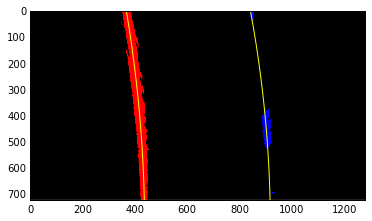

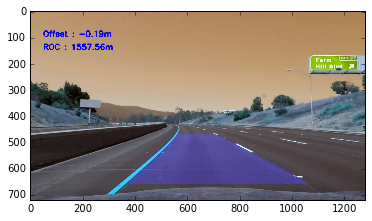

In [35]:
image = cv2.imread('./Linear/j.png')
undist = undistort(image)
warped = preprocess(undist)
l_fit, r_fit, a = findLines(warped, 50, True)
plt.imshow(drawOnImage(warped, undist, l_fit, r_fit))

In [36]:
class Line():
    """Class to hold previous detected Lines"""
    BUFFER_SIZE = 30
    def __init__(self):
        # Last n good fits
        self.last_n_fits = [np.array([0,0,0], dtype='float')]
        # Last good fit
        self.last_fit = None
        # if the line was detected in last frame
        self.last_detected = False
        # Average of the previous fits
        self.average_fit = None
        # Number of lines this object is currently holding
        self.num_lines = len(self.last_n_fits)
        # Number of consective misses
        self.misses = 4
    
    def addLine(self, fit):
        """Add a good line"""
        self.last_n_fits.append(fit)
        self.last_fit = fit
        if len(self.last_n_fits) > Line.BUFFER_SIZE:
            self.last_n_fits.pop(0)
        self.average_fit = np.mean(np.vstack(self.last_n_fits), axis=0)
        self.last_detected = True
        self.misses = 0
        self.num_lines = len(self.last_n_fits)
    
    def checkLine(self, fit):
        """ax2 + bx + c"""
        if self.average_fit is not None:
            delta_coef = np.absolute(fit - self.average_fit)
#             print (delta_coef[0])
            if delta_coef[0] > 1e-20:
                return False
            else:
                return True
        else:
            return True
    
    def getLastFit(self):
        self.last_detected = False
        self.misses += 1
        return np.mean(np.vstack(self.last_n_fits[-3:]), axis=0)
    
    def getSmoothLine(self, fit):
        self.last_n_fits.append(fit)
        smooth = np.mean(np.vstack(self.last_n_fits[-4:]), axis=0)
        self.last_n_fits.pop(-1)
        return smooth

In [37]:
right_lines = Line()
left_lines = Line()

In [ ]:
def trackingLines(image, debug=False):
    """Track lines from previous frames"""
    global right_lines
    global left_lines
    
    warped = preprocess(image)
    margin = 100
    
    minpix = 3800
    
    # Start Here
    if left_lines.num_lines < 4:
        l_fit, r_fit, n_idx = findLines(warped, 50, debug=debug)
        left_lines.addLine(l_fit)
        right_lines.addLine(r_fit)
        return l_fit, r_fit, warped
    
    r_found = False
    l_found = False
    l_use_last = False
    r_use_last = False
    
    # If missed more than 5:
    if left_lines.misses > 10 or right_lines.misses > 10:
        l_fit, r_fit, n_idx = findLines(warped, 50, debug=debug)
        if n_idx[0] < minpix:
            l_use_last = True
        if n_idx[1] < minpix:
            r_use_last = True
    
        # If low confidence use average of last three fits
        if l_use_last:
            l_fit = left_lines.getLastFit()
            l_found = True
        else:
            left_lines.addLine(l_fit)
            l_fit = left_lines.getSmoothLine(l_fit)
            l_found = True
        
    
        if r_use_last:
            r_fit = right_lines.getLastFit()
            r_found = True
        else:
            right_lines.addLine(r_fit)
            r_fit = right_lines.getSmoothLine(r_fit)
            r_found = True
        if debug:
            print("Started over!", l_use_last, r_use_last)
        return l_fit, r_fit, warped
    
    # Use last line to detect lane pixels
    # Left Line >>>>>>>>>>>>>>>>>>>>>>>>>
    
    nonzero = warped.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    usable, fit = useLastFit(nonzero_x, nonzero_y, left_lines.last_fit, margin)
    if usable:
        left_lines.addLine(fit)
        l_fit = left_lines.getSmoothLine(fit)
    else:
        left_lines.misses += 1
        l_fit = left_lines.getLastFit()
    if debug:
        print ("Left usable? ", usable)
    
    usable, fit = useLastFit(nonzero_x, nonzero_y, right_lines.last_fit, margin)
    if usable:
        right_lines.addLine(fit)
        r_fit = right_lines.getSmoothLine(fit)
    else:
        right_lines.misses += 1
        r_fit = right_lines.getLastFit()
    if debug:
        print ("Right usable? ", usable)
    
    return l_fit, r_fit, warped

In [40]:
# debug = True to visualise
right_lines = Line()
left_lines = Line()
def videoPipe(image):
    """Function to apply to each frame in the video"""
    undist = undistort(image)
    BGR = cv2.cvtColor(undist, cv2.COLOR_RGB2BGR)
    l_fit, r_fit, warped = trackingLines(BGR, False)
    result = drawOnImage(warped, undist, l_fit, r_fit)
    return result

** Process Video **

---

The video will be saved in `output.mp4`

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_lines = Line()
right_lines = Line()
white_output = './output.mp4'
clip1 = VideoFileClip("./project_video.mp4")

white_clip = clip1.fl_image(videoPipe) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Here
[MoviePy] >>>> Building video ./output.mp4
[MoviePy] Writing video ./output.mp4


  0%|          | 1/1261 [00:00<05:23,  3.89it/s]

Here


  0%|          | 2/1261 [00:00<05:25,  3.86it/s]

Here


 90%|█████████ | 1137/1261 [08:23<01:06,  1.85it/s]